# A Crash Course on Bayesian Analysis Using Python
I personally think that Bayesian analysis could be extremely useful in the work we do.  With this blog post I'm going to try to convince you of that while also introducing the basics of Bayesian analysis and the python programming language.  I should state up front that I am not an expert in Bayesian analysis.  

## Why Bayes?
I am currently involved in a five arm RCT for a client here in India.  The decision this evaluation seeks to influence is which treatment arms the client should drop and which they should continue to implement.  In order to make this decision, the client wants to know the probability of each treatment arm having the largest effect.  Unfortunately, it's hard to give a straight answer to that question using the typical frequentist approach to analysis.  Instead, we can answers questions like "what is the probability that we would see data as extreme as this if treatment arm 1 and treatment arm 2 actually have the same effect" or "what is the probability that we would see data this extreme if treatment arm 1 actually has no effect."  

In the rest of blog post, I'll provide a small toy example demonstrating how Bayesian analysis can be used to answer this question.  In subsequent blog posts, I hope to show other ways in which Bayesian analysis could be useful for our work.

## Step 1: Generate Some Data
In future blog posts, I hope to use real client data to demonstrate this approach but for now let's start with some fake data.  To generate some fake data, I assume the true data generating process for the RCT is...

$$ y_i \sim N(\alpha+\tau_{j[i]},\sigma_y^2) $$

Where i indexes households, j indexes treatment arms, and j = 0 indicates the control group and thus $\tau_0=0$. I pick arbitrary values for the parameters. 

In [91]:
# generate some data using numpy
import numpy as np

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 2, 1
tau = [0,.5,1.6,2,0,-0.7]

# Size of each treatment arm
size_arms = np.array([20, 10, 10, 20, 20, 15])

# Simulate outcome variable
Y = alpha + np.repeat(tau, size_arms)+ np.random.randn(sum(size_arms))*sigma

In [92]:
np.take(tau,arm)

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  1.6,  1.6,  1.6,
        1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  2. ,  2. ,  2. ,  2. ,
        2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,
        2. ,  2. ,  2. ,  2. ,  2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. , -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7,
       -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7])

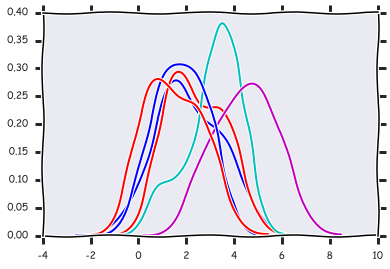

In [93]:
# let's graph this data to make sure that it looks approximately right
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# this next line makes all your graphs look like those form XKCD
plt.xkcd()
start = 0
for size in size_arms:
    end = start + size
    sns.distplot(Y[start:end], hist = False)
    start = end

This appears to be about what we would expect give our effect sizes.

## Step 2: Fit the Data Using PyMC3
Great.  We've generated some data.  Now we use PyMC3 to fit that data using a Bayesian hierarchical model.

In [114]:
# Generate a matrix X which, which multiplied by tau yields a vector of the appropriate taus.
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
arm = np.repeat(np.arange(6),size_arms)
X =enc.fit_transform(arm.reshape(-1,1))  

<1x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [140]:
arm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5])

In [142]:
# dfdsfa
import pymc3 as pm
with pm.Model() as model:
    # Define priors
    alpha_m = pm.Normal('alpha_m', mu=0, sd=2)
    tau_m = pm.Normal('tau_m', mu=0, sd=2, shape=6)
    print(type(tau_m))
    sigma_m = pm.HalfNormal('sigma_m', sd=3)

    # Define likelihood
    mu = alpha_m + tau_m[arm]
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma_m, observed=Y)
    
    # Perform inference
    trace = pm.sample(2000)

<class 'pymc3.model.FreeRV'>
Applied log-transform to sigma_m and added transformed sigma_m_log to model.
Assigned NUTS to alpha_m
Assigned NUTS to tau_m
Assigned NUTS to sigma_m_log
 [-----------------100%-----------------] 2000 of 2000 complete in 5.3 sec

In [143]:
pm.summary(trace)


alpha_m:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.149            0.753            0.045            [0.747, 3.683]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.704          1.632          2.146          2.647          3.655


tau_m:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.033           0.787            0.046            [-1.628, 1.421]
  0.256            0.806            0.045            [-1.449, 1.714]
  0.946            0.815            0.045            [-0.746, 2.459]
  2.254            0.786            0.045            [0.708, 3.796]
  -0.353           0.776            0.045            [-1.980, 1.116]
  -0.653           0.787            0.045            [-